# Plotting With SparkMagic on Hops

To run large scale computations in a hops cluster from Jupyter we use sparkmagic, a livy REST server, and the pyspark kernel. 

The fact that the default computation on a cluster is distributed over several machines makes it a little different to do things such as plotting compared to when running code locally. 

This notebook illustrates how you can combine plotting and large-scale computations on a Hops cluster in a single notebook.

In [ ]:
# When pyspark kernel is started we get a Spark session automatically created for us
spark

##  Check which "magic" functions are avilable from sparkmagic

In [2]:
%%help

Magic,Example,Explanation
info,%%info,Outputs session information for the current Livy endpoint.
cleanup,%%cleanup -f,"Deletes all sessions for the current Livy endpoint, including this notebook's session. The force flag is mandatory."
delete,%%delete -f -s 0,Deletes a session by number for the current Livy endpoint. Cannot delete this kernel's session.
logs,%%logs,Outputs the current session's Livy logs.
configure,"%%configure -f{""executorMemory"": ""1000M"", ""executorCores"": 4}",Configure the session creation parameters. The force flag is mandatory if a session has already been created and the session will be dropped and recreated.Look at Livy's POST /sessions Request Body for a list of valid parameters. Parameters must be passed in as a JSON string.
spark,%%spark -o dfdf = spark.read.parquet('...,"Executes spark commands. Parameters: -o VAR_NAME: The Spark dataframe of name VAR_NAME will be available in the %%local Python context as a Pandas dataframe with the same name. -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a dataframe that will be pulled from Livy to Jupyter. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
sql,%%sql -o tables -qSHOW TABLES,"Executes a SQL query against the variable sqlContext (Spark v1.x) or spark (Spark v2.x). Parameters: -o VAR_NAME: The result of the SQL query will be available in the %%local Python context as a Pandas dataframe. -q: The magic will return None instead of the dataframe (no visualization). -m, -n, -r are the same as the %%spark parameters above."
local,%%locala = 1,All the code in subsequent lines will be executed locally. Code must be valid Python code.


## Load a CSV file in Spark

The pokemon csv file is available [here](https://www.kaggle.com/abcsds/pokemon)

In [3]:
from hops import hdfs
df = spark.read.format("csv").option("header", "true").load(hdfs.project_path() + "TourData/visualization/Pokemon.csv")

In [4]:
df.count()

800

In [5]:
df.show(5)

+---+--------------------+------+------+-----+---+------+-------+-------+-------+-----+----------+---------+
|  #|                Name|Type 1|Type 2|Total| HP|Attack|Defense|Sp. Atk|Sp. Def|Speed|Generation|Legendary|
+---+--------------------+------+------+-----+---+------+-------+-------+-------+-----+----------+---------+
|  1|           Bulbasaur| Grass|Poison|  318| 45|    49|     49|     65|     65|   45|         1|    False|
|  2|             Ivysaur| Grass|Poison|  405| 60|    62|     63|     80|     80|   60|         1|    False|
|  3|            Venusaur| Grass|Poison|  525| 80|    82|     83|    100|    100|   80|         1|    False|
|  3|VenusaurMega Venu...| Grass|Poison|  625| 80|   100|    123|    122|    120|   80|         1|    False|
|  4|          Charmander|  Fire|  null|  309| 39|    52|     43|     60|     50|   65|         1|    False|
+---+--------------------+------+------+-----+---+------+-------+-------+-------+-----+----------+---------+
only showing top 5 

## Name the Spark DataFrame to Be Able to Use SQL

In [6]:
df.createOrReplaceTempView("pokemons")

## Use SparkMagic to Collect the Spark Dataframe as a Pandas Dataframe Locally

This command will send the dataset from the cluster to the server where Jupyter is running and convert it into a pandas dataframe. This is only suitable for smaller datasets. A common practice is to run spark jobs to process a large dataset and shrink it before plotting, notice that in this case we use the `--maxrows 10` flag to limit the amount of data we download. The command below makes the result of the SQL query available as a pandas dataframe called `python_df` in `%%local`.

In [7]:
%%sql -c sql -o python_df --maxrows 10
SELECT * FROM pokemons

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oSFRNTCh2YWx1ZT11J1R5cGU6JyksIEJ1dHRvbihkZXNjcmlwdGlvbj11J1RhYmxlJywgbGF5b3V0PUxheW91dCh3aWR0aD11JzcwcHgnKSzigKY=


Output()

You can also download a spark dataframe from the cluster to a local pandas dataframe without using SQL, by using the `%%spark magic`. The command below makes the spark dataframe called "df" available as pandas dataframe called `df` in `%%local`.

In [8]:
%%spark -o df 

## The Pandas DataFrames are now Available in %%local mode

In [9]:
%%local
df

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oSFRNTCh2YWx1ZT11J1R5cGU6JyksIEJ1dHRvbihkZXNjcmlwdGlvbj11J1RhYmxlJywgbGF5b3V0PUxheW91dCh3aWR0aD11JzcwcHgnKSzigKY=


Output()

In [10]:
%%local
python_df

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oSFRNTCh2YWx1ZT11J1R5cGU6JyksIEJ1dHRvbihkZXNjcmlwdGlvbj11J1RhYmxlJywgbGF5b3V0PUxheW91dCh3aWR0aD11JzcwcHgnKSzigKY=


Output()

In [ ]:
%%local
python_df["Name"].values

If plotting libraries are not already installed locally, you can install them as follows:

In [ ]:
%%bash
pip install --user matplotlib
pip install --user seaborn

## Local Plotting with MatplotLib and Seaborn

After the Data Have Been Loaded Locally as a pandas dataframe, it can get plotted on the Jupyter server. By using the magic "%%local" at the top of a cell, the code in the cell will be executed locally on the Jupyter server, rather than remotely with Livy on the Spark cluster. Once the pandas dataframe is available locally it can be plotted with libraries such as matplotlib and seaborn. <span style="color:red">remember to add the line: %matplotlib inline </span>

In [ ]:
%%local
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

#### Pokemon Plotting Credits:

- Chinmay Rane: https://www.kaggle.com/fuzzywizard/pokemon-visualization-with-seaborn
- Vincent Liao: https://www.kaggle.com/fuzzywizard/pokemon-visualization-with-seaborn
- iammax2Seaborn: https://www.kaggle.com/iammax2/seaborn-tutorial-exploration-with-pokemon-data

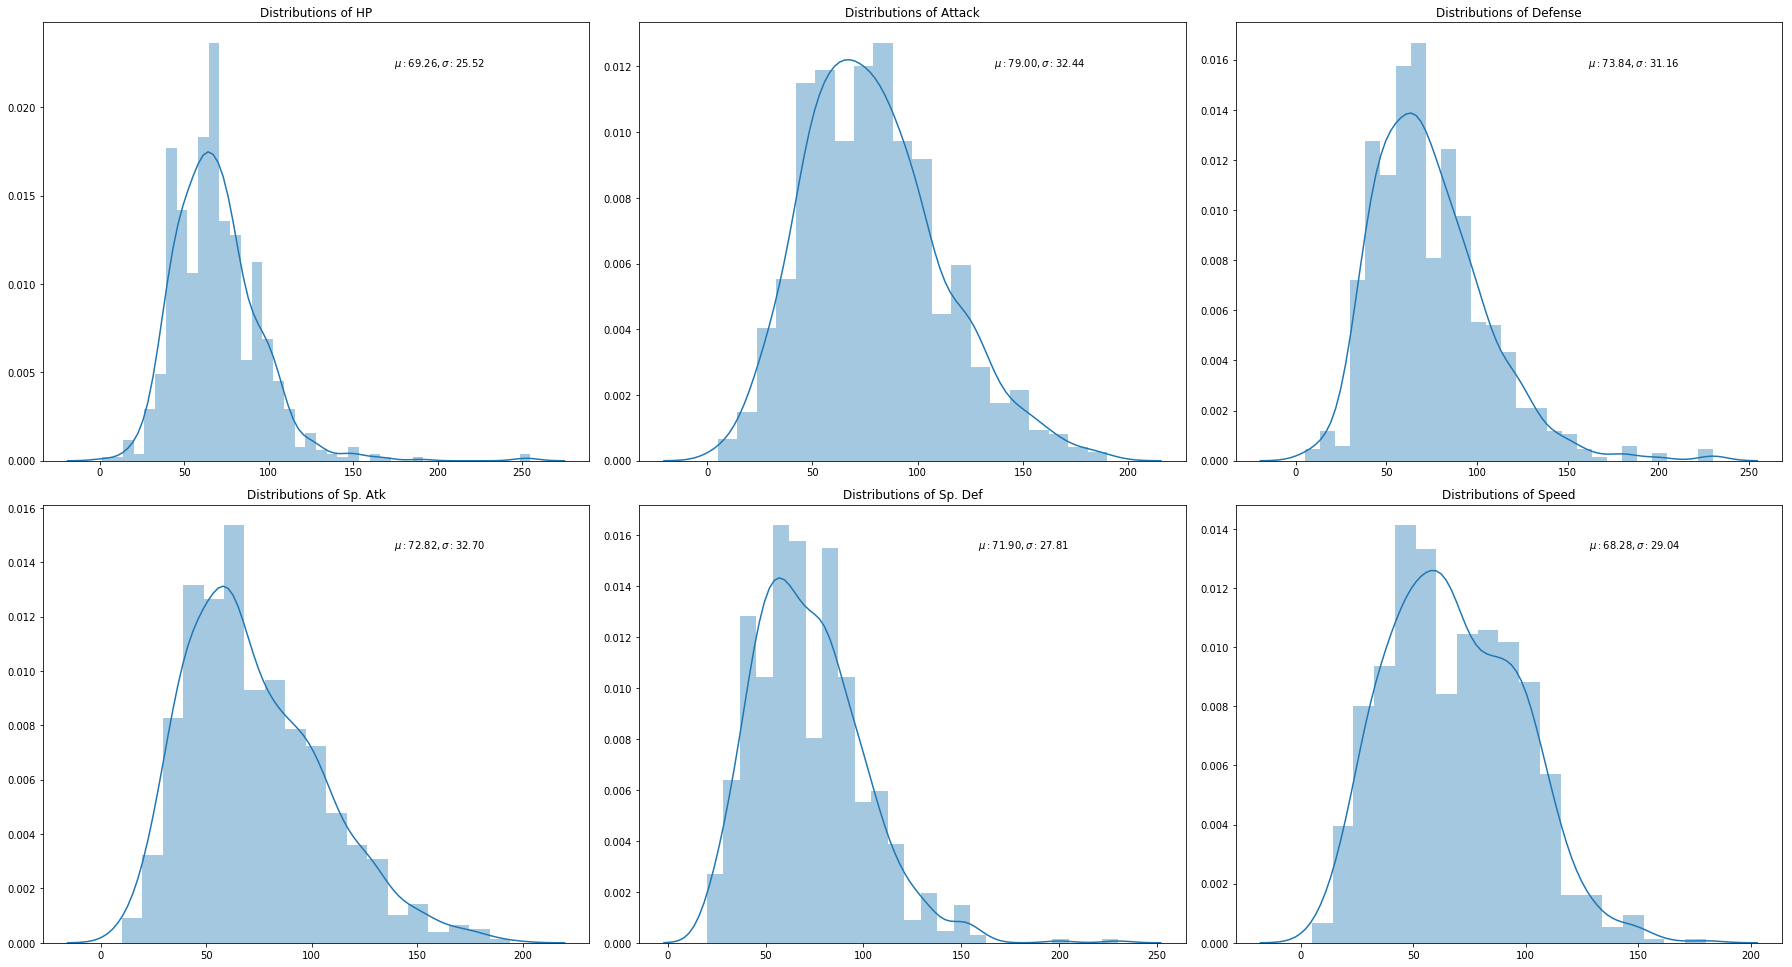

In [14]:
%%local
stats = df.columns[5:11]
plt.figure(figsize=(25, 20))

for ii, stat in enumerate(stats):
    title = "Distributions of {stat}".format(
        stat = stat
    )
    plt.subplot(3, 3, ii+1)
    plt.title(title)
    stats = np.array(map(lambda x: int(x), df[stat].values))
    sns.distplot(stats)
    x = plt.gca().get_xlim()[1] * .6
    y = plt.gca().get_ylim()[1] * .9
    plt.text(x, y, '$\mu: {mu: .2f}, \sigma: {sigma: .2f}$'.format(mu = stats.mean(), sigma=stats.std()))
    
    
plt.tight_layout()
plt.show()

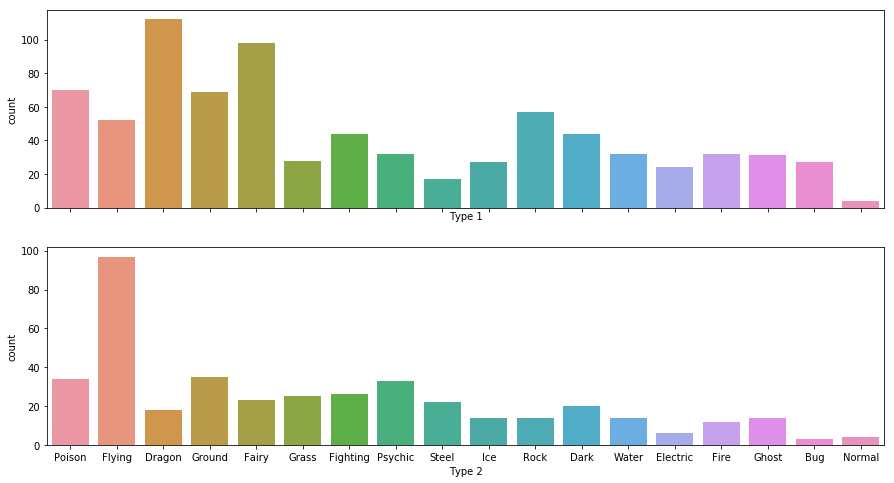

In [15]:
%%local
#view the nuumber of pokemons for Type 1 and Type 2 using one plot
f, (ax1,ax2) = plt.subplots(2,1,figsize=(15, 8),sharex=True)

sns.countplot('Type 1',data=df,ax=ax1)
sns.countplot('Type 2',data=df,ax=ax2)

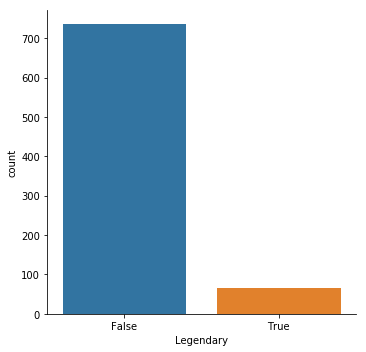

In [16]:
%%local
sns.catplot(x='Legendary',kind='count',data=df,height=5,aspect=1)

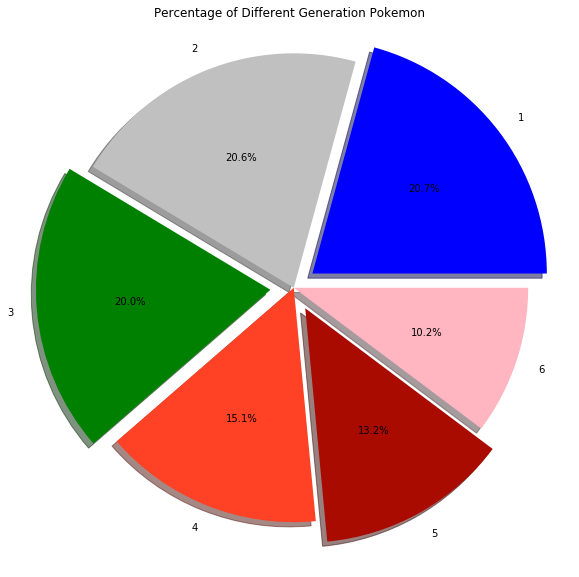

In [17]:
%%local
df['Type 2'].fillna( df['Type 1'] , inplace = True)
# Visualize 'Generation' via Pie-Chart
labels = df['Generation'].unique().tolist()
sizes = df['Generation'].value_counts().tolist()
cols = ['B', 'silver', 'G', '#ff4125', '#aa0b00', '#FFB6C1']
explode = ( 0.1 , 0 , 0.1 , 0 , 0.1 , 0 )

plt.pie(sizes,labels=labels,colors=cols,explode=explode,shadow=True,autopct='%1.1f%%',startangle=0)
plt.axis('equal')
plt.title("Percentage of Different Generation Pokemon")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

/srv/hops/jupyter/.local/lib/python2.7/site-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



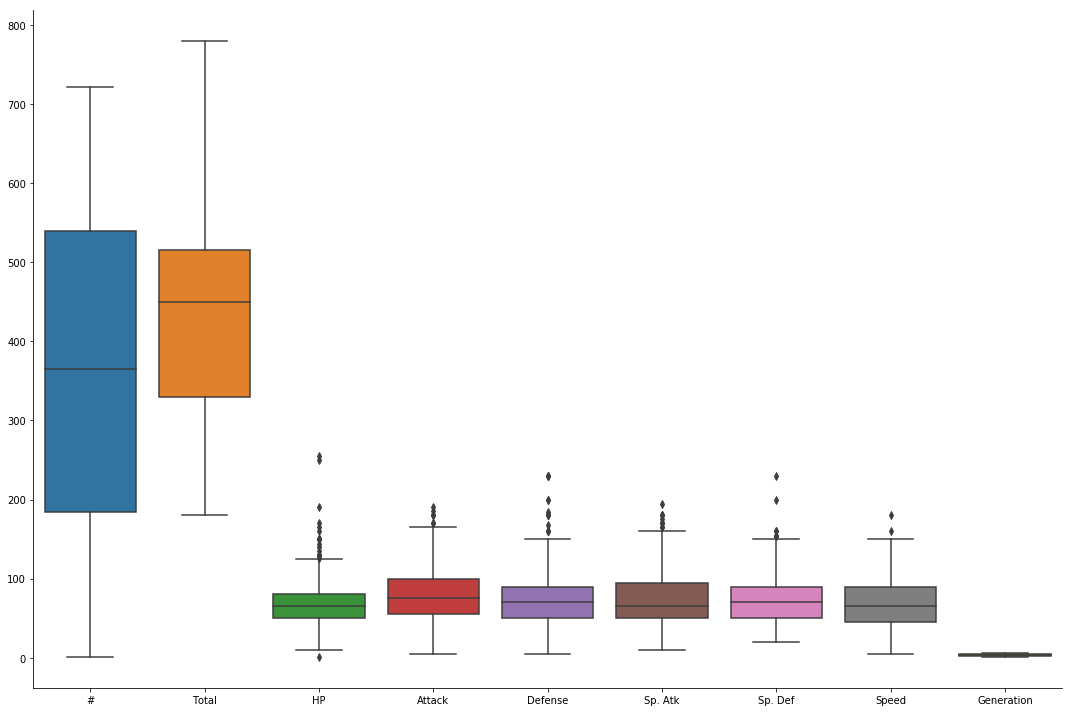

In [18]:
%%local
sns.factorplot(data=df,kind='box',height=10,aspect=1.5)

In [19]:
%%local
def comp(Type,category,feature1,feature2,color):
    type_poke = df.loc[df[Type]==category]
    ax=sns.kdeplot(type_poke[feature1],type_poke[feature2],cmap=color, shade=True, shade_lowest=False)

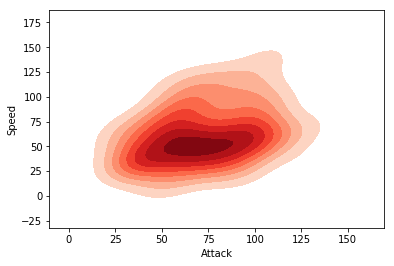

In [20]:
%%local
comp('Type 1','Grass','Attack','Speed','Reds')

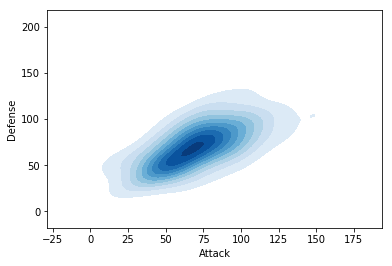

In [21]:
%%local
comp('Type 1','Water','Attack','Defense','Blues')

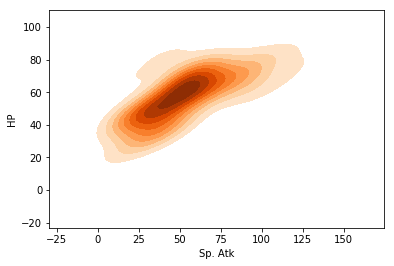

In [22]:
%%local
comp('Type 1','Bug','Sp. Atk','HP','Oranges')

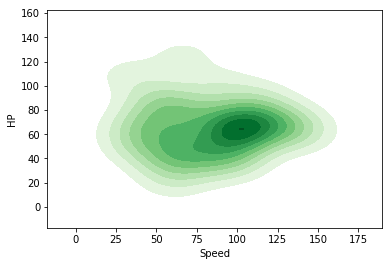

In [23]:
%%local
comp('Type 2','Electric','Speed','HP','Greens')

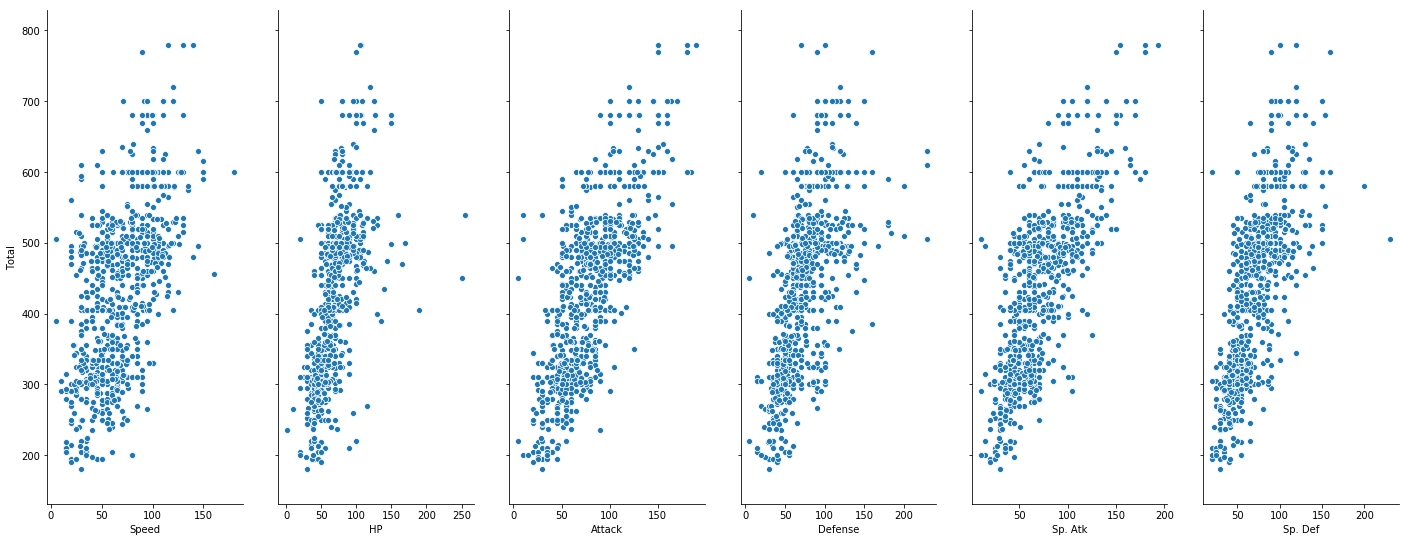

In [24]:
%%local
g=sns.pairplot(data=df,y_vars=['Total'],x_vars=['Speed','HP','Attack','Defense','Sp. Atk','Sp. Def'])
g.fig.set_size_inches(20,10)

In [25]:
%%local
def comp2(Type,Attribute):
    fig, ax = plt.subplots(3,1)
    fig.set_size_inches(20,20)
    sns.swarmplot(x=Type,y=Attribute,ax=ax[0],data=df)
    sns.violinplot(x=Type,y=Attribute,ax=ax[1],data=df)
    sns.barplot(x=Type,y=Attribute,ax=ax[2],data=df)

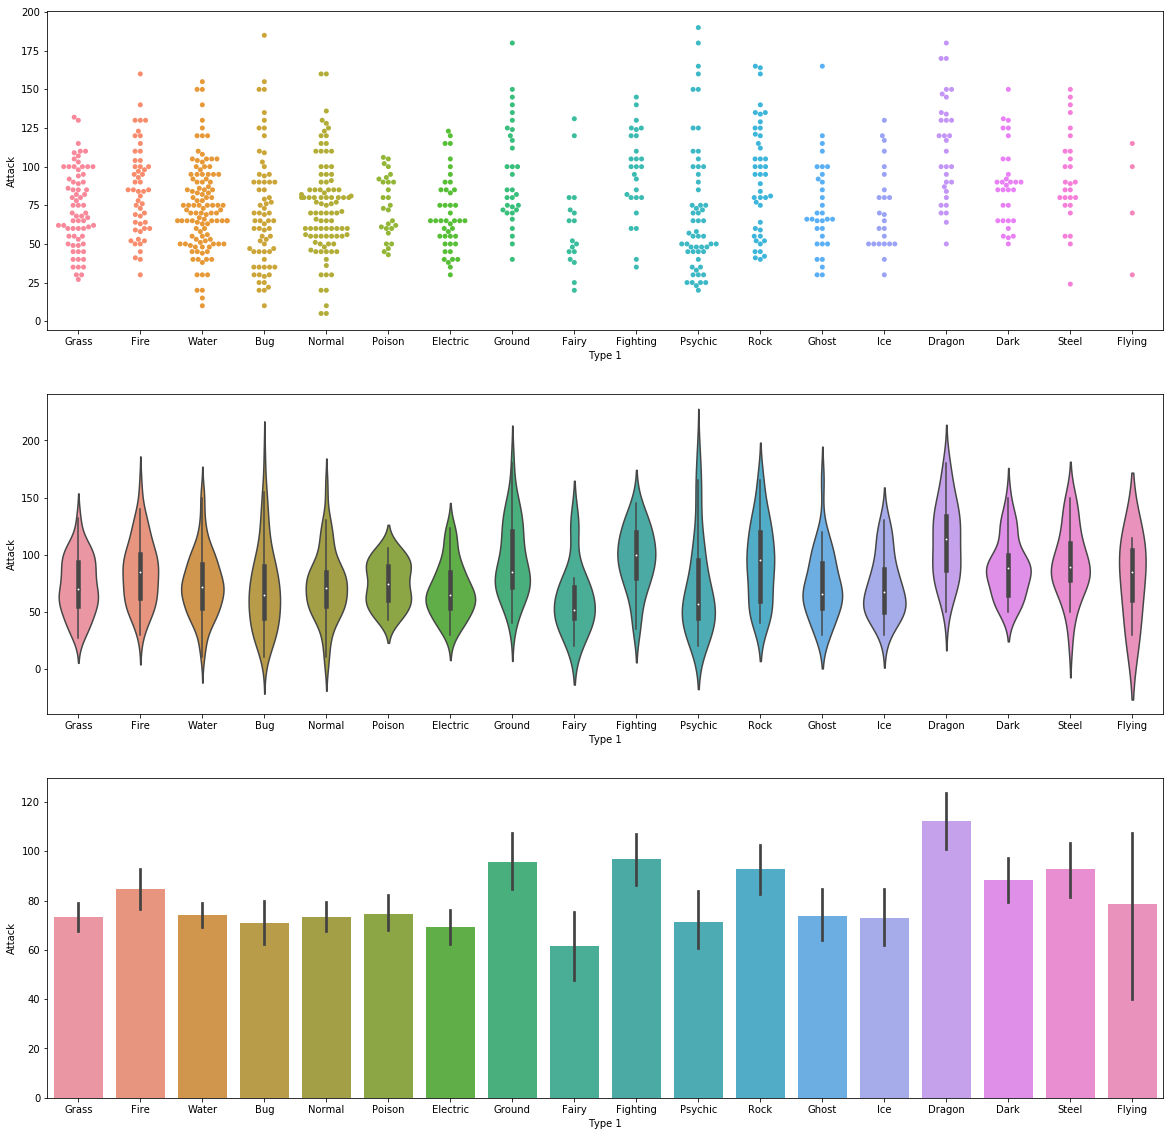

In [26]:
%%local
comp2('Type 1','Attack')

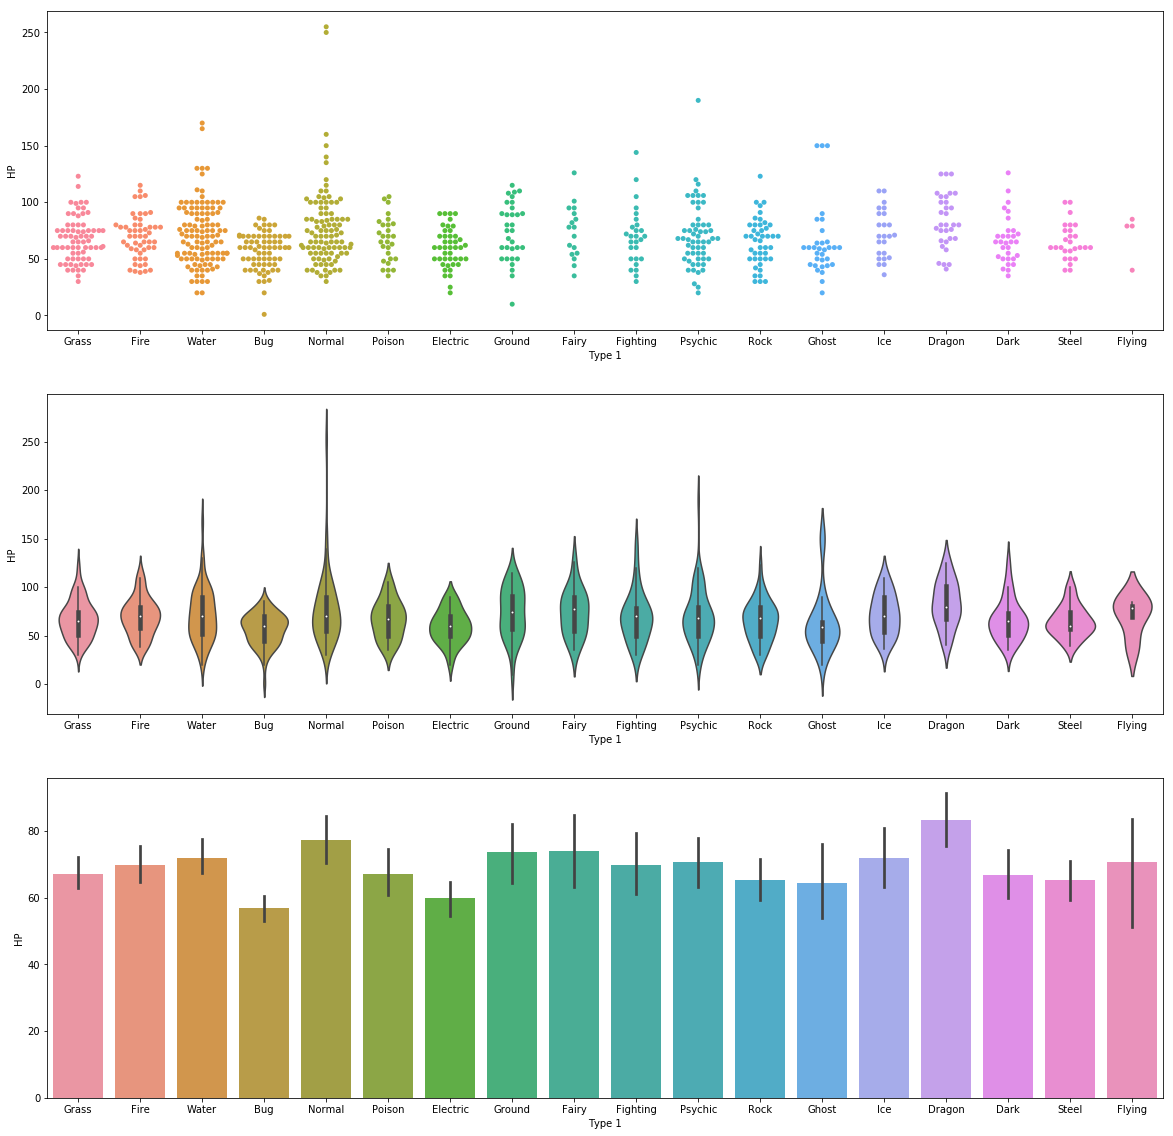

In [27]:
%%local
comp2('Type 1','HP')

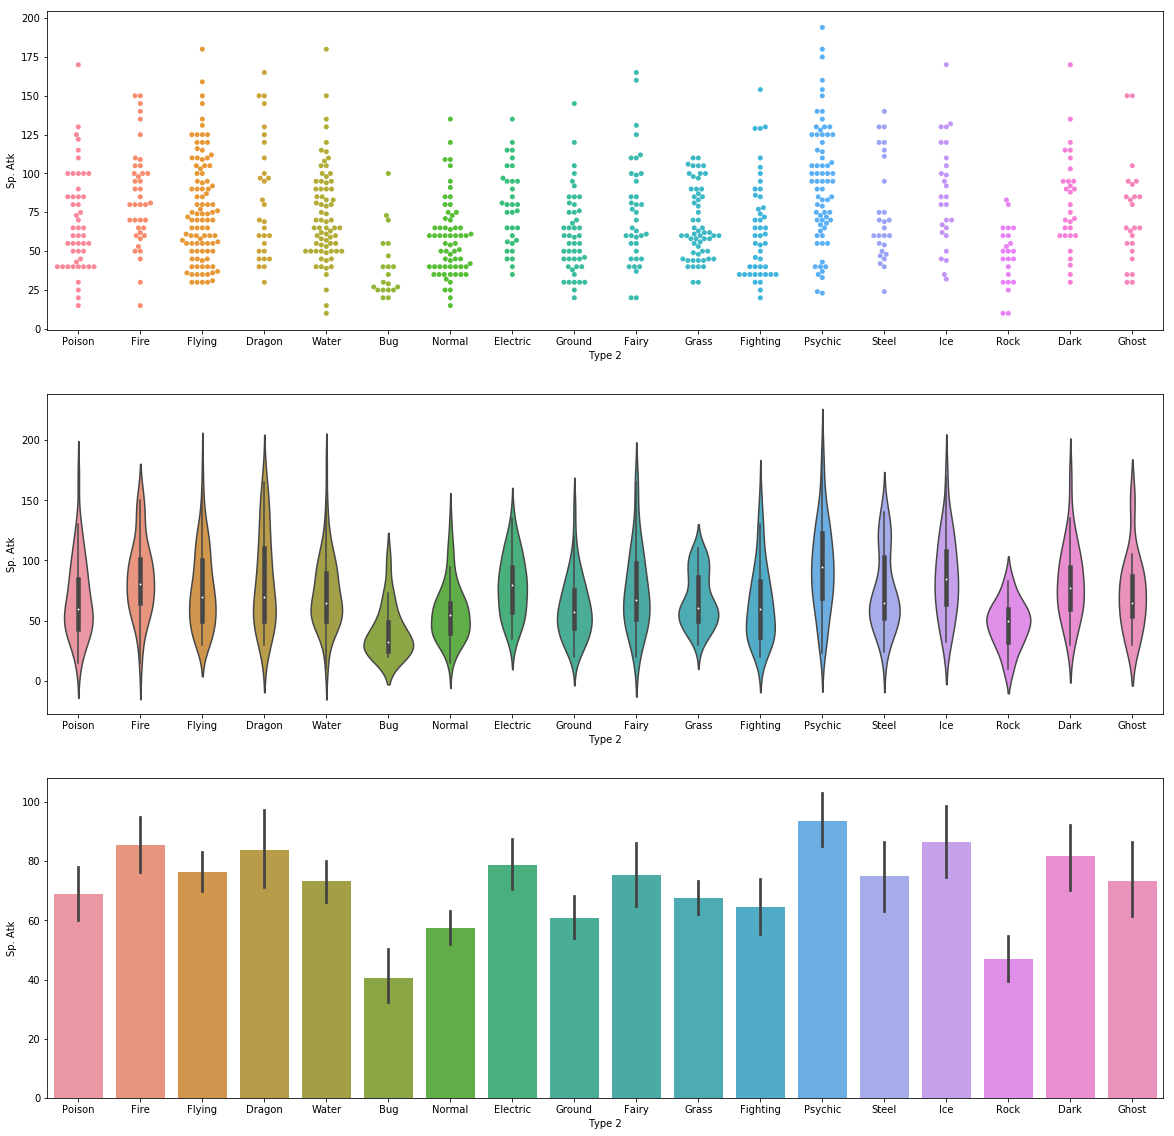

In [28]:
%%local
comp2('Type 2', 'Sp. Atk')

In [29]:
%%local
def comp_hex(Attribute1,Attribute2,Color):
    sns.jointplot(x=Attribute1, y=Attribute2, data=df, color =Color , kind ='hex', height = 8.0)
    plt.show()

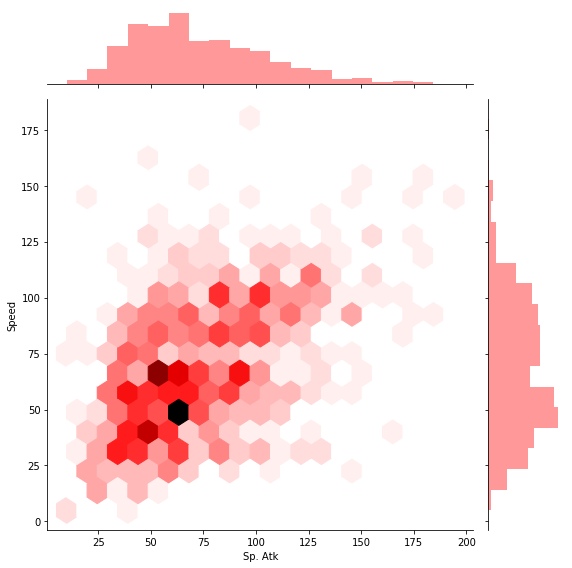

In [30]:
%%local
comp_hex('Sp. Atk','Speed','Red')

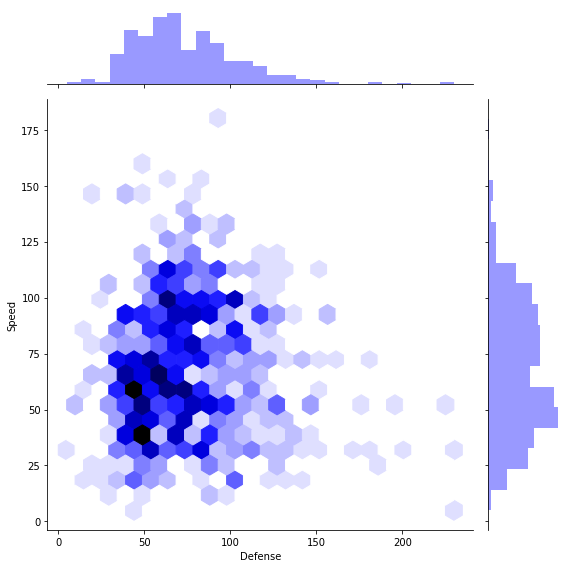

In [31]:
%%local
comp_hex('Defense','Speed','Blue')

In [32]:
%%local
group_df = df.drop(['#', 'Legendary'], axis=1)
pokemon_groups = group_df.groupby('Generation')
pokemon_groups_mean = pokemon_groups.mean()

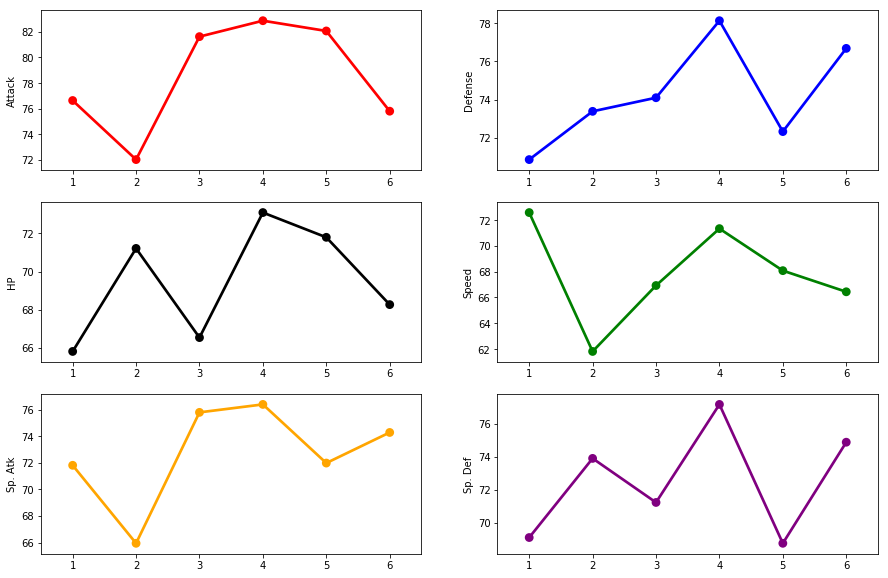

In [33]:
%%local
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Attack'], color='red', ax=axes[0][0])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Defense'], color='blue', ax=axes[0][1])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['HP'], color='black', ax=axes[1][0])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Speed'], color='green', ax=axes[1][1])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Sp. Atk'], color='orange', ax=axes[2][0])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Sp. Def'], color='purple', ax=axes[2][1])

plt.show()

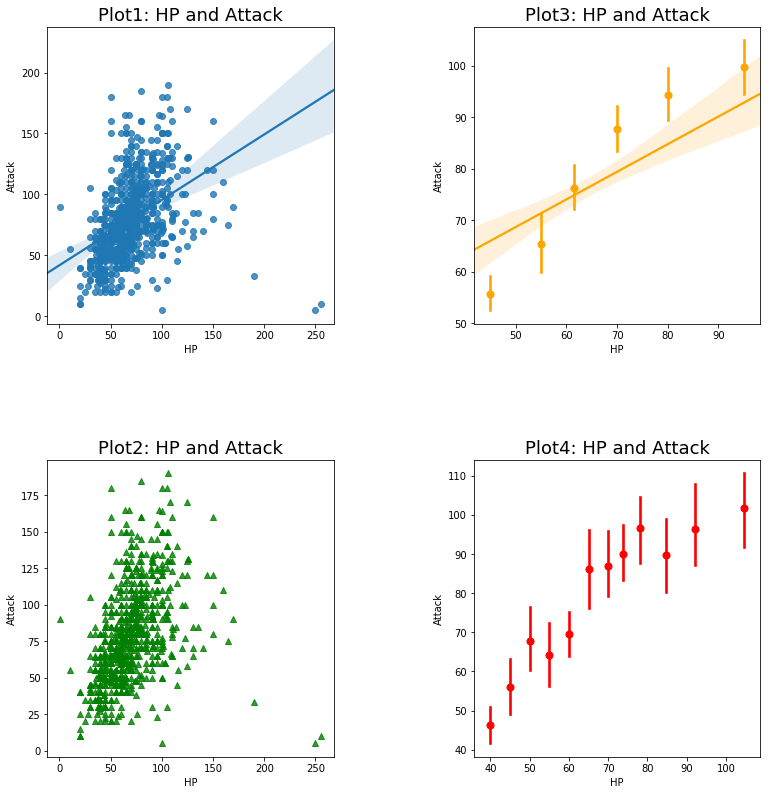

In [34]:
%%local
pkmn = df.drop(["Generation", "Legendary"], 1) # [dataframe].drop([COLUMN NAMES]) will remove
# certain columns from a data frame. Generation and Legendary data are not important for this 
# analysis so they were dropped.

pkmn.head() # the [dataframe_name].head() command will show the first five rows of data frame
# This can be useful to see the effects of a change, like the .drop() command in the previous 
# line of code

fig, axs = plt.subplots(2, 2, figsize = (12,12)) #plt.subplots() first two arguements are the number
# of rows and then the number of columns. The [figsize =] adjusts the size of the final output of graphs.
# See point and link 2 

ax1 = plt.subplot2grid((8,8), (0,0), rowspan=3, colspan=3) 
ax2 = plt.subplot2grid((8,8), (4,0), rowspan=3, colspan=3)
ax3 = plt.subplot2grid((8,8), (0, 4), rowspan=3, colspan=3)
ax4 = plt.subplot2grid((8,8), (4, 4), rowspan=3, colspan=3)

# ^Each one of the above ax commands positions each graph spot within a grid. 
# For a better understanding see point and link 4


fig.tight_layout() # To understand how this works see point and link 3

ax1.set_title("Plot1: HP and Attack", fontsize =18)
ax2.set_title("Plot2: HP and Attack", fontsize =18)
ax3.set_title("Plot3: HP and Attack", fontsize =18)
ax4.set_title("Plot4: HP and Attack", fontsize =18)

# ^The above code purely sets the title of each graph and the fontsize



# Plot 1
sns.regplot(x='HP', y='Attack', 
              data=pkmn, ax=ax1) #x_bins = 12, fit_reg = True, ci = 95, 
              #color = 'red', marker ="^", ax=ax1) 
# Notice the x and y are set columns of the pkmn dataset. The [ax =]
# is added because we have subplots and Python needs to know where to put this graph.
# But this graph has no customization, just the bare bones. 


# Plot 2 
sns.regplot(x='HP', y='Attack', 
              data=pkmn, fit_reg = False, color = 'green', marker ="^", ax=ax2)
# We're going to add some parameters. We'll add a [color =], [fit_reg =],
# [marker =] command to our function. The [color =] command let's us control the color 
# of the graph and the points. The [fit_reg =] command allows use to turn on/off the linear
# regression and just see the points. The default is True, unless we change it to False.
# The final addition is the [marker =] command, this changes the marker used on the graph to 
# mark the points.


# Plot 3
sns.regplot(x='HP', y='Attack', 
              data=pkmn, fit_reg = True, x_bins = 6, color = 'orange', ax=ax3)
# We're going to add some parameters still. Now we're adding the [x_bins =] command, and changing
# [fit_reg =] to True. The [x_bins =] commands seperates our data into bins, the number given is the number
# of bins the data is sepperated into. The [x_bins =] command also gives a confidence interval
# to the bins. This confidence interval is the verticle line running through the point. 
# The default is confidence interval is 95%, but that can be changed if needed. So in this plot
# we have 6 points each with a confidence interval, and linear regression running through
# our data. 


# Plot 4
sns.regplot(x='HP', y='Attack', 
              data=pkmn, fit_reg = False, x_bins = 12, ci = 99, color = 'red', ax=ax4)
# I like what we did with the last graph, so I'm going to add to that. But I don't like
# the line running through the data, I want the graph to be red, I want more bins, and I 
# want the confidence on each point to be 99% percent instead of 95%. To do this I turned
# [fit_reg =] to False, [color =] to 'red', [x_bins =] to 12, and introduced a new command, 
# the [ci =] command. This command sets the confidence interval of both the bins AND the line.
# In this exampe we don't have a linear fit to the data, so the [ci =] will only effect the bins.



plt.show() # This command shows the graphs we've plotted

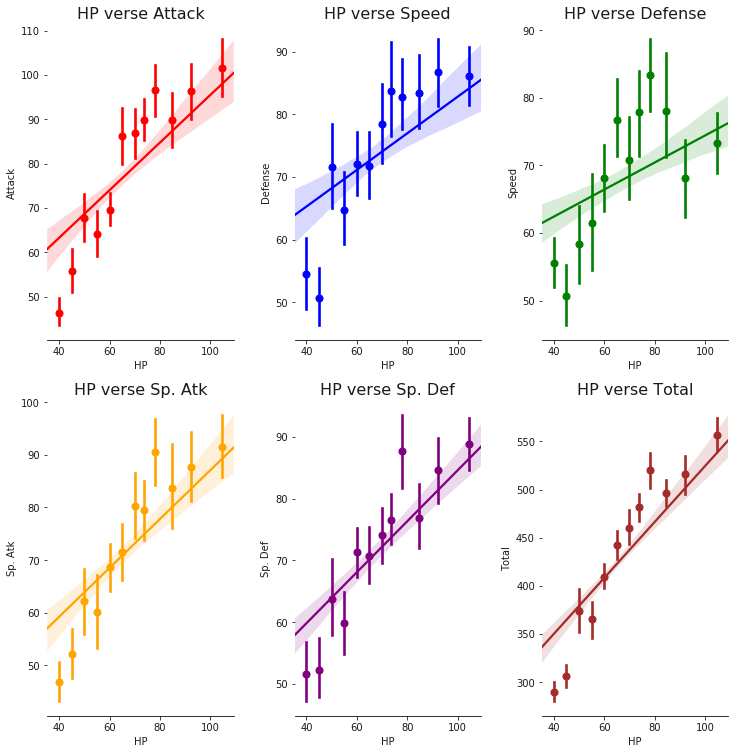

In [35]:
%%local
fig, axs = plt.subplots(4, 6, figsize = (10,10)) # I changed the figure size as well as the number 
# of rows and columns in my final figure because now I want a (2 x 3) display of images!

ax1 = plt.subplot2grid((4, 6), (0, 0), rowspan=2, colspan=2) 
ax2 = plt.subplot2grid((4, 6), (0, 2), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((4, 6), (0, 4), rowspan=2, colspan=2)
ax4 = plt.subplot2grid((4, 6), (2, 0), rowspan=2, colspan=2)
ax5 = plt.subplot2grid((4, 6), (2, 2), rowspan=2, colspan=2)
ax6 = plt.subplot2grid((4, 6), (2, 4), rowspan=2, colspan=2)

# ^I changed the axs locations to match the new (2 x 3) display I want to use.


fig.tight_layout(pad = 0.4, w_pad = 3.0, h_pad = 4.0) # To understand how this works see point and link 3 
# of the previous plot

ax1.set_title("HP verse Attack", fontsize =16)
ax2.set_title("HP verse Speed", fontsize =16)
ax3.set_title("HP verse Defense", fontsize =16)
ax4.set_title("HP verse Sp. Atk", fontsize =16)
ax5.set_title("HP verse Sp. Def", fontsize =16)
ax6.set_title("HP verse Total", fontsize =16)

# ^The above code purely sets the title of each graph and the fontsize

sns.regplot(x='HP', y='Attack', 
              data=pkmn, x_bins = 12, fit_reg = True, ci = 90, color = 'red', ax=ax1) 

sns.regplot(x='HP', y='Defense', 
              data=pkmn, x_bins = 12, fit_reg = True, ci = 90, color = 'blue', ax=ax2)

sns.regplot(x='HP', y='Speed', 
              data=pkmn, x_bins = 12, fit_reg = True, ci = 90, color = 'green', ax=ax3)

sns.regplot(x='HP', y='Sp. Atk', 
              data=pkmn, x_bins = 12, fit_reg = True, ci = 90, color = 'orange', ax=ax4)

sns.regplot(x='HP', y='Sp. Def', 
              data=pkmn, x_bins = 12, fit_reg = True, ci = 90, color = 'purple', ax=ax5)

sns.regplot(x='HP', y='Total', 
              data=pkmn, x_bins = 12, fit_reg = True, ci = 90, color = 'brown', ax=ax6)

sns.set(style="whitegrid") # aesthetics
sns.despine(left=True) # aesthetics
sns.set_context("paper") # aesthetics

plt.show()

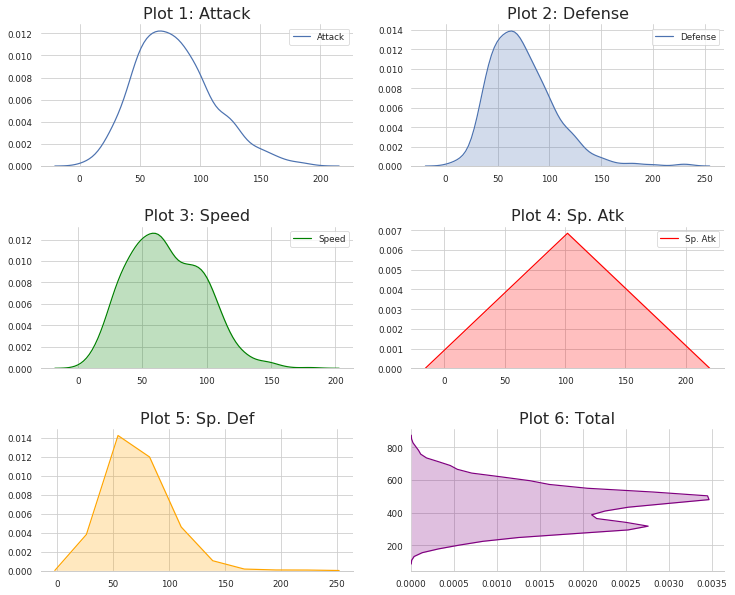

In [36]:
%%local
fig, axs = plt.subplots(6, 4, figsize = (10,8)) # I changed the figure size as well as the number 
# of rows and columns in my final figure because now I want a (3 x 2) display of images!

ax1 = plt.subplot2grid((6, 4), (0, 0), rowspan=2, colspan=2) 
ax2 = plt.subplot2grid((6, 4), (0, 2), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((6, 4), (2, 0), rowspan=2, colspan=2)
ax4 = plt.subplot2grid((6, 4), (2, 2), rowspan=2, colspan=2)
ax5 = plt.subplot2grid((6, 4), (4, 0), rowspan=2, colspan=2)
ax6 = plt.subplot2grid((6, 4), (4, 2), rowspan=2, colspan=2)

# ^I changed the axs locations to match the new (3 x 2) display I want to use.


fig.tight_layout(pad = 0.4, w_pad = 3.0, h_pad = 4.0) # To understand how this works see point and link 3 
# of the section 2

ax1.set_title("Plot 1: Attack", fontsize =16)
ax2.set_title("Plot 2: Defense", fontsize =16)
ax3.set_title("Plot 3: Speed", fontsize =16)
ax4.set_title("Plot 4: Sp. Atk", fontsize =16)
ax5.set_title("Plot 5: Sp. Def", fontsize =16)
ax6.set_title("Plot 6: Total", fontsize =16)

# ^The above code purely sets the title of each graph and the fontsize


# Plot 1:

sns.kdeplot(pkmn.Attack, ax=ax1) 
# This .kdeplot represents the bare minimum. Just x data, and the specifc plot to 
# be graphed on.


# Plot 2:

sns.kdeplot(pkmn.Defense, shade = True, ax=ax2)
# Beyond the basic graph, we've now added a command [shade =]'s. This command accepts
# a boolean value of eith True/False. True turns the shading on, the default is False.


# Plot 3:

sns.kdeplot(pkmn.Speed, shade = True, color = "green", ax=ax3)
# On top of the previous commands, we've added a [color =]'s command to change the color
# of our graph


# Plot 4:

sns.kdeplot(pkmn["Sp. Atk"], shade = True, color = "red", gridsize = 3, ax=ax4)
# Now this graph should look pretty strange in comparison to the other graphs. That's
# because I've added a [girdsize =]'s command. This command changes the number of discrete
# points used to evaluate the grid. I set it to 3 to really see its effect on a density plot.
# Including the begining and the end, notice it only has 4 point on the graph. This is 
# helpful when graphing data that you don't want to smooth over, where the rough edges are
# important to the overall graph.


# Plot 5:

sns.kdeplot(pkmn["Sp. Def"], shade = True, color = "orange", gridsize = 10, legend = False, ax=ax5)
# In this graph, I simply changed the [gridsize =]'s to 10, and added a new command, [legend =]'s.
# Notice all the other graphs place a legend in our graph by default. Well if we don't want the legend
# simply set the [legend =]'s command to False. 


# Plot 6:

sns.kdeplot(pkmn.Total, shade = True, vertical = True, color = "purple", gridsize = 35, 
            legend = False, ax=ax6)
# In this graph I set [gridsize =]'s to 35, this will smooth the graph but still add a small
# level of roughness to the density plot. Then I introduced a new command, the [vertical =]'s command
# This command will flip the x and y axises, graphing density on the x-axis. 


sns.set_style("whitegrid") # aesthetics
sns.despine(left=True) # aesthetics
sns.set_context("paper") # aesthetics

plt.show()

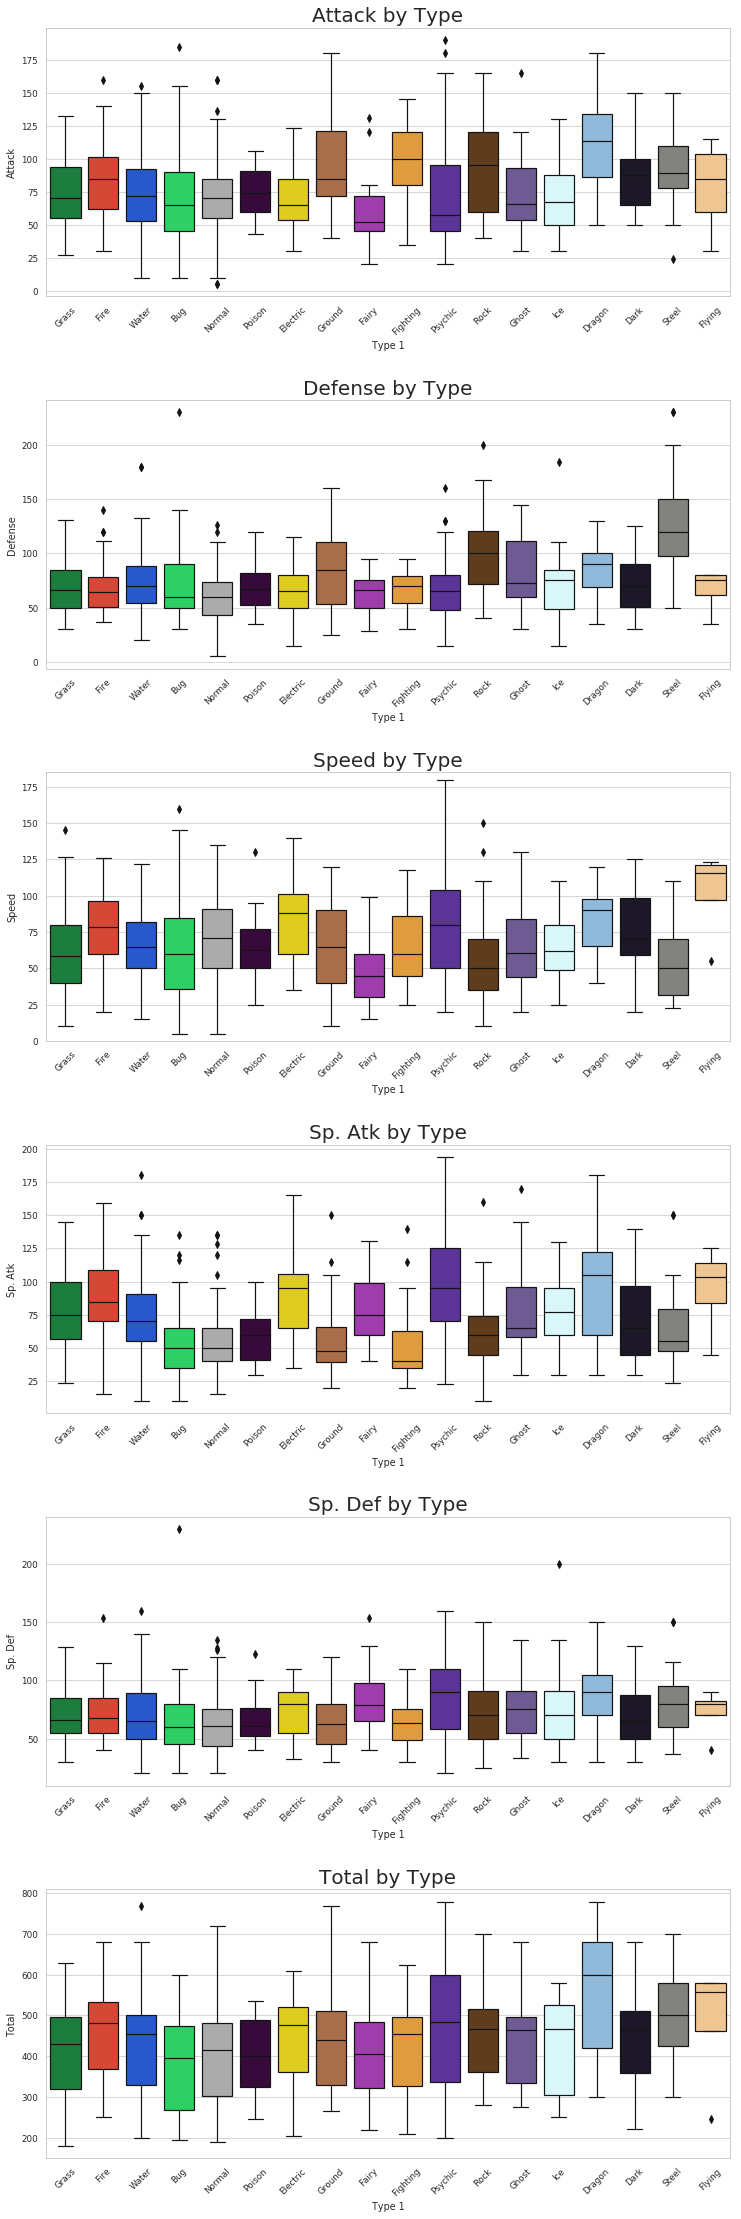

In [37]:
%%local
pokemon_color_palette = dict({"Water":"#0D4EE5", "Normal":"#ABABAB", "Bug":"#13EA5D", "Grass":"#0C8D39", "Psychic":"#5823A8",
 "Fire":"#EF341B", "Electric":"#ffe500", "Rock":"#6A3D11", "Dragon":"#85BAE5", "Fairy":"#AC2ABE",
"Ground":"#B96B3B", "Poison":"#3C0344", "Ghost":"#6B529C", "Fighting":"#FAA124", "Steel":"#82827f",
"Ice":"#D3FCFF", "Flying":"#ffc882", "Dark":"#1b152b"})

# In order to get the colors right in the box plot, I had to create a dictionary matching the types
# to the colors I wanted to display. This way done manually using 
fig, axs = plt.subplots(6, 1, figsize = (10,30))

ax1 = plt.subplot2grid((6, 1), (0, 0)) 
ax2 = plt.subplot2grid((6, 1), (1, 0))
ax3 = plt.subplot2grid((6, 1), (2, 0))
ax4 = plt.subplot2grid((6, 1), (3, 0))
ax5 = plt.subplot2grid((6, 1), (4, 0))
ax6 = plt.subplot2grid((6, 1), (5, 0))


fig.tight_layout(pad = 0.4, w_pad = 3.0, h_pad = 8.5)

ax1.set_title("Attack by Type", fontsize =20)
ax2.set_title("Defense by Type", fontsize =20)
ax3.set_title("Speed by Type", fontsize =20)
ax4.set_title("Sp. Atk by Type", fontsize =20)
ax5.set_title("Sp. Def by Type", fontsize =20)
ax6.set_title("Total by Type", fontsize =20)
ax3.set_ylim(0, 185)

# The code for the box plots are fairly simply. It's just an x and y input, a [data =] input, and 
# a color palette input (which I created in the panel above this one).

sns.boxplot(x = "Type 1", y = "Attack",
            data = pkmn, palette = pokemon_color_palette,  ax=ax1) 


sns.boxplot(x = "Type 1", y = "Defense",
            data = pkmn, palette = pokemon_color_palette, ax=ax2)


sns.boxplot(x = "Type 1", y = "Speed", 
            data = pkmn, palette = pokemon_color_palette, ax=ax3)


sns.boxplot(x = "Type 1", y = "Sp. Atk",
            data = pkmn, palette = pokemon_color_palette, ax=ax4)


sns.boxplot(x = "Type 1", y = "Sp. Def", 
            data = pkmn, palette = pokemon_color_palette, ax=ax5)


sns.boxplot(x = "Type 1", y = "Total", 
            data = pkmn, palette = pokemon_color_palette, ax=ax6)

sns.set_context("paper") # aesthetics
sns.set(style="whitegrid", palette="muted")

for ax in fig.axes: # see side note in panel below
    plt.sca(ax)
    plt.xticks(rotation= 45)

plt.show()

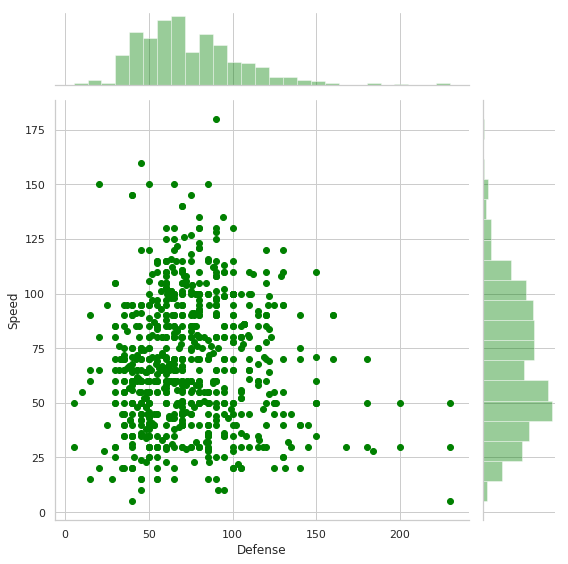

In [41]:
%%local
sns.jointplot(x='Defense', y='Speed', 
              data=pkmn, color ='green', kind ='scatter', 
              height = 8.0)
plt.show()

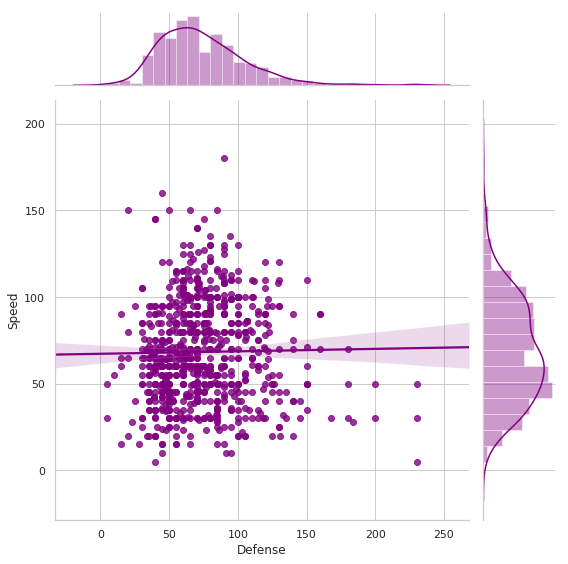

In [39]:
%%local
sns.jointplot(x='Defense', y='Speed', 
              data=pkmn, color ='purple', kind ='reg', 
              size = 8.0)
plt.show()